<a href="https://colab.research.google.com/github/xandeea/BootCamp-Dados-Alura/blob/main/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**COVID-19 - Clinical Data to assess diagnosis**
https://www.kaggle.com/S%C3%ADrio-Libanes/covid19

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
import warnings
warnings.filterwarnings("ignore")
!pip install openpyxl==3.0.0

     |████████████████████████████████| 172 kB 5.4 MB/s 
  Created wheel for openpyxl: filename=openpyxl-3.0.0-py2.py3-none-any.whl size=241207 sha256=c6253f9e0775c364d295ff2f89e9df77e90e0598edd788ef1e3d0e97ec0a7392
  Stored in directory: /root/.cache/pip/wheels/c7/64/ff/ce98f6e1d2701ae8e216c875da62feed2839ac8a3cae0ab8af
Successfully built openpyxl
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.9
    Uninstalling openpyxl-3.0.9:
      Successfully uninstalled openpyxl-3.0.9


In [ ]:
dados = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")

In [ ]:
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [ ]:
dados.shape

(1925, 231)

In [ ]:
dados.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,...,821.000000,821.000000,821.0,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,0.158333,0.809896,0.528527,0.528527,0.528527,0.528527,-1.0,-0.963433,-0.963433,-0.963433,-0.963433,-1.0,-0.931121,-0.931121,-0.931121,-0.931121,-1.0,-0.310924,-0.310924,-0.310924,-0.310924,-1.0,-0.311845,-0.311845,-0.311845,-0.311845,-1.0,-0.945928,-0.945928,-0.945928,...,-0.954177,-0.954177,-1.0,-0.093631,-0.332600,-0.264701,-0.438754,0.066893,0.743077,-0.097790,-0.338468,-0.268632,-0.435121,0.063798,0.748588,-0.040855,-0.207812,-0.264999,-0.483129,0.326823,0.817565,-0.235001,-0.399582,-0.282029,-0.316753,0.014964,0.818593,-0.752454,-0.728053,-0.754100,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,0.365148,0.392485,0.224100,0.224100,0.224100,0.224100,0.0,0.160870,0.160870,0.160870,0.160870,0.0,0.169509,0.169509,0.169509,0.169509,0.0,0.100256,0.100256,0.100256,0.100256,0.0,0.118812,0.118812,0.118812,0.118812,0.0,0.076610,0.076610,0.076610,...,0.123582,0.123582,0.0,0.252064,0.274102,0.246760,0.217113,0.242858,0.132635,0.257733,0.277952,0.252709,0.225554,0.249208,0.125994,0.281304,0.277802,0.272725,0.278239,0.216198,0.283453,0.271123,0.287580,0.296247,0.402675,0.276163,0.141316,0.364001,0.408677,0.366349,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000

# **Tratamento da base de dados**

### De acordo com o hospital Sírio Libanês, que disponibilizou os dados, é razoável supor que um paciente que não tenha o dado dos exames registrado em alguma das janelas de horas, possua o mesmo resultado que a janela anterior ou seguinte

### Porém, a recomendação do hospital se aplica apenas aos exames realizados pelos pacientes, não as outras informações

In [ ]:
# Verificando as colunas com dados nulos
dados.isnull().sum().sort_values()[:20]

PATIENT_VISIT_IDENTIFIER          0
WINDOW                            0
GENDER                            0
ICU                               0
AGE_ABOVE65                       0
AGE_PERCENTIL                     0
OTHER                             5
IMMUNOCOMPROMISED                 5
HTN                               5
DISEASE GROUPING 1                5
DISEASE GROUPING 5                5
DISEASE GROUPING 4                5
DISEASE GROUPING 3                5
DISEASE GROUPING 2                5
DISEASE GROUPING 6                5
BLOODPRESSURE_DIASTOLIC_DIFF    685
BLOODPRESSURE_DIASTOLIC_MIN     685
BLOODPRESSURE_DIASTOLIC_MAX     685
BLOODPRESSURE_SISTOLIC_MAX      685
HEART_RATE_MAX                  685
dtype: int64

In [ ]:
# Descobrindo quais pacientes estão com dados faltantes nas colunas que não são de exames
dados.loc[(dados['DISEASE GROUPING 1'].isna())]

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
995,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,0
996,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-4,0
997,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
998,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6-12,0
999,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABOVE_12,0


In [ ]:
# Só 1 paciente possui dados faltantes nessas outras colunas, portanto, vou remover as linhas do paciente sem dados preenchidos
dados.drop(dados.index[995:1000], 0, inplace=True)
dados.shape

(1920, 231)

In [ ]:
# Completando colunas de exames com os resultados de exames anteriores ou posteriores 
dados_limpos = dados.groupby('PATIENT_VISIT_IDENTIFIER', as_index=False).fillna(method='ffill').fillna(method='bfill')
dados_limpos.insert(0, 'PATIENT_VISIT_IDENTIFIER', dados['PATIENT_VISIT_IDENTIFIER'])

In [ ]:
dados_limpos.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,-0.107143,0.736842,0.333333,-0.230769,-0.132075,-0.586207,-0.107143,0.736842,0.443299,0.0000,-0.025641,-0.500000,0.318681,0.898990,-0.076923,-0.459459,-0.313433,-0.63636

In [ ]:
# Também de acordo com o hospital, os dados de pacientes na janela em que entram na UTI não devem ser utilizados pois não se sabe se os exames foram feitos antes ou após sua entrada
# Portanto, vamos excluir os pacientes que entraram na UTI já no primeiro horário
colunas_a_remover = dados_limpos.loc[(dados_limpos['WINDOW'] == '0-2') & (dados_limpos['ICU'] == 1)]['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @colunas_a_remover")

In [ ]:
dados_limpos.shape

(1760, 231)

In [ ]:
# Para o modelo, iremos apenas utilizar a janela de 0-2, pois quanto antes identificada a necessidade do paciente ir para a UTI, melhor será
# Portanto, preencheremos com 1 todas as pessoas que foram para a UTI, independente da janela na qual foi
def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0

# **Análise exploratória dos dados**

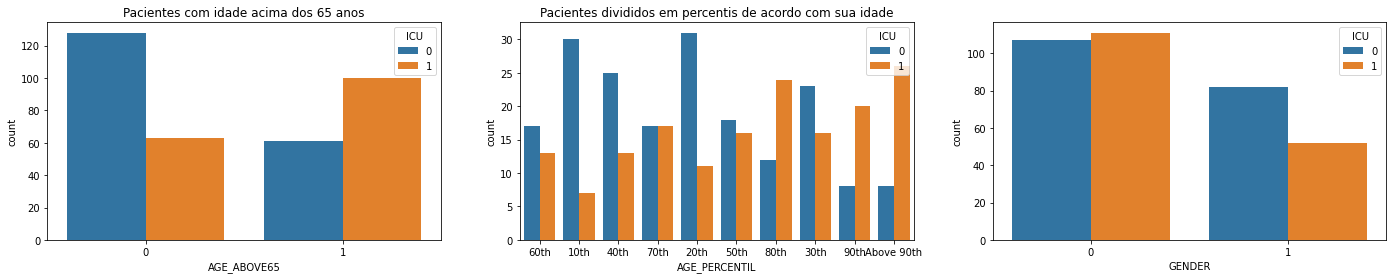

In [ ]:
fig, axis = plt.subplots(nrows = 1, ncols = 3, figsize = (24, 4))
sns.countplot(dados_limpos['AGE_ABOVE65'], hue=dados_limpos['ICU'], ax = axis[0])
axis[0].set_title("Pacientes com idade acima dos 65 anos")
sns.countplot(dados_limpos['AGE_PERCENTIL'],hue=dados_limpos['ICU'], ax = axis[1])
axis[1].set_title("Pacientes divididos em percentis de acordo com sua idade")
sns.countplot(dados_limpos['GENDER'],hue=dados_limpos['ICU'], ax = axis[2])
plt.show(fig)

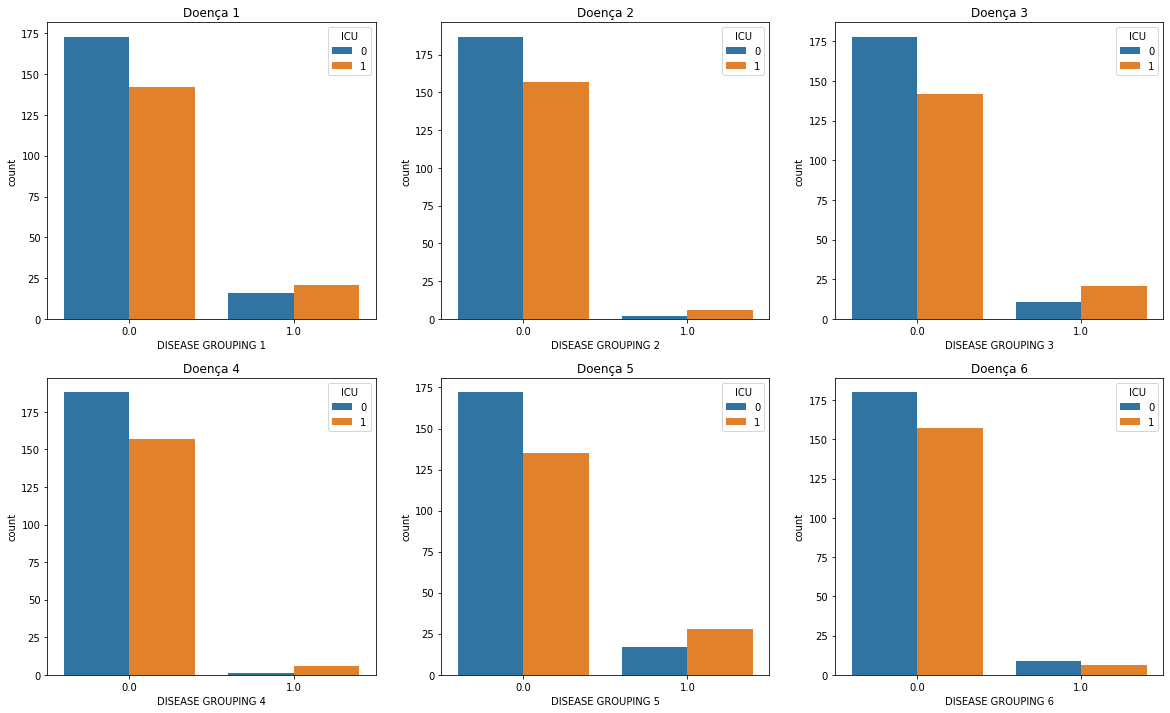

In [ ]:
fig, axis = plt.subplots(nrows = 2, ncols = 3, figsize = (20,12))
sns.countplot(dados_limpos['DISEASE GROUPING 1'], hue=dados_limpos['ICU'],ax = axis[0,0])
axis[0,0].set_title("Doença 1")
sns.countplot(dados_limpos['DISEASE GROUPING 2'],hue=dados_limpos['ICU'], ax = axis[0,1])
axis[0,1].set_title("Doença 2")
sns.countplot(dados_limpos['DISEASE GROUPING 3'],hue=dados_limpos['ICU'], ax = axis[0,2])
axis[0,2].set_title("Doença 3")
sns.countplot(dados_limpos['DISEASE GROUPING 4'],hue=dados_limpos['ICU'], ax = axis[1,0])
axis[1,0].set_title("Doença 4")
sns.countplot(dados_limpos['DISEASE GROUPING 5'],hue=dados_limpos['ICU'], ax = axis[1,1])
axis[1,1].set_title("Doença 5")
sns.countplot(dados_limpos['DISEASE GROUPING 6'],hue=dados_limpos['ICU'], ax = axis[1,2])
axis[1,2].set_title("Doença 6")
plt.show(fig)

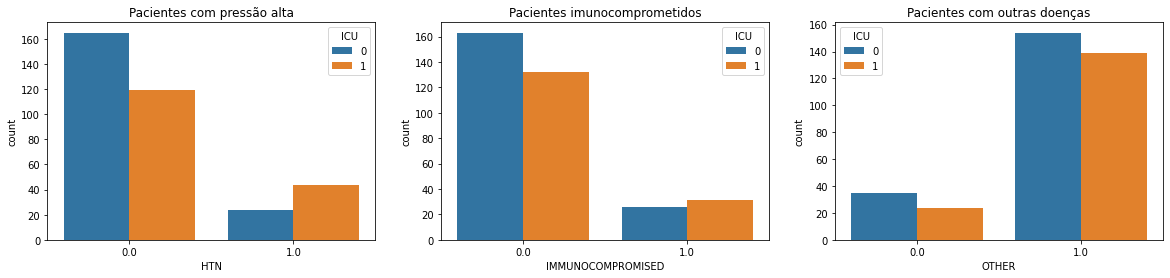

In [ ]:
fig, axis = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 4))
sns.countplot(dados_limpos['HTN'],hue=dados_limpos['ICU'], ax = axis[0])
axis[0].set_title("Pacientes com pressão alta")
sns.countplot(dados_limpos['IMMUNOCOMPROMISED'], hue=dados_limpos['ICU'], ax = axis[1])
axis[1].set_title("Pacientes imunocomprometidos")
sns.countplot(dados_limpos['OTHER'], hue=dados_limpos['ICU'], ax = axis[2])
axis[2].set_title("Pacientes com outras doenças")
plt.show(fig)

# **Convertendo as colunas categóricas para implementação do modelo**

In [ ]:
dados_limpos.select_dtypes(include="object")

,,AGE_PERCENTIL,WINDOW
PATIENT_VISIT_IDENTIFIER,,,
0,0,60th,0-2
2,10,10th,0-2
3,15,40th,0-2
4,20,10th,0-2
5,25,10th,0-2
...,...,...,...
380,1900,40th,0-2
381,1905,Above 90th,0-2
382,1910,50th,0-2


In [ ]:
# Convertendo a coluna object que será usada para o modelo
label_encoder = LabelEncoder()
dados_limpos['AGE_PERCENTIL'] = label_encoder.fit_transform(dados_limpos['AGE_PERCENTIL'])

# **Criação do Modelo**

In [ ]:
y = dados_limpos['ICU']
x = dados_limpos.drop(['ICU', 'WINDOW'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((264, 229), (88, 229), (264,), (88,))

In [ ]:
  modelo_arvore = RandomForestClassifier(n_estimators=100, random_state=0)
  modelo_arvore.fit(X_train, y_train)

  predicao = modelo_arvore.predict(X_test)
  roc_auc_score(y_test, predicao)

0.7954545454545456

In [ ]:
from sklearn.metrics import roc_auc_score
k_vs_score = []

for k in range(2,230,2):
  selector = SelectKBest(score_func=f_classif, k=k)

  Xtrain2 = selector.fit_transform(X_train, y_train)
  Xtest2 = selector.transform(X_test)

  mdl = RandomForestClassifier(n_estimators=100, random_state=0)
  mdl.fit(Xtrain2, y_train)

  p = mdl.predict(Xtest2)

  score = roc_auc_score(y_test, p)
  
  print("k = {} - ROC_AUC = {}".format(k, score))

  k_vs_score.append(score)

k = 2 - ROC_AUC = 0.49999999999999994
k = 4 - ROC_AUC = 0.49999999999999994
k = 6 - ROC_AUC = 0.6818181818181819
k = 8 - ROC_AUC = 0.6931818181818181
k = 10 - ROC_AUC = 0.7045454545454546
k = 12 - ROC_AUC = 0.6704545454545454
k = 14 - ROC_AUC = 0.7045454545454546
k = 16 - ROC_AUC = 0.7272727272727273
k = 18 - ROC_AUC = 0.7727272727272727
k = 20 - ROC_AUC = 0.75
k = 22 - ROC_AUC = 0.8181818181818181
k = 24 - ROC_AUC = 0.7727272727272727
k = 26 - ROC_AUC = 0.8295454545454546
k = 28 - ROC_AUC = 0.784090909090909
k = 30 - ROC_AUC = 0.7840909090909092
k = 32 - ROC_AUC = 0.784090909090909
k = 34 - ROC_AUC = 0.7727272727272727
k = 36 - ROC_AUC = 0.7954545454545454
k = 38 - ROC_AUC = 0.7727272727272727
k = 40 - ROC_AUC = 0.7954545454545454
k = 42 - ROC_AUC = 0.7954545454545454
k = 44 - ROC_AUC = 0.7840909090909091
k = 46 - ROC_AUC = 0.7954545454545454
k = 48 - ROC_AUC = 0.8295454545454546
k = 50 - ROC_AUC = 0.7840909090909091
k = 52 - ROC_AUC = 0.7954545454545454
k = 54 - ROC_AUC = 0.772727272

[]

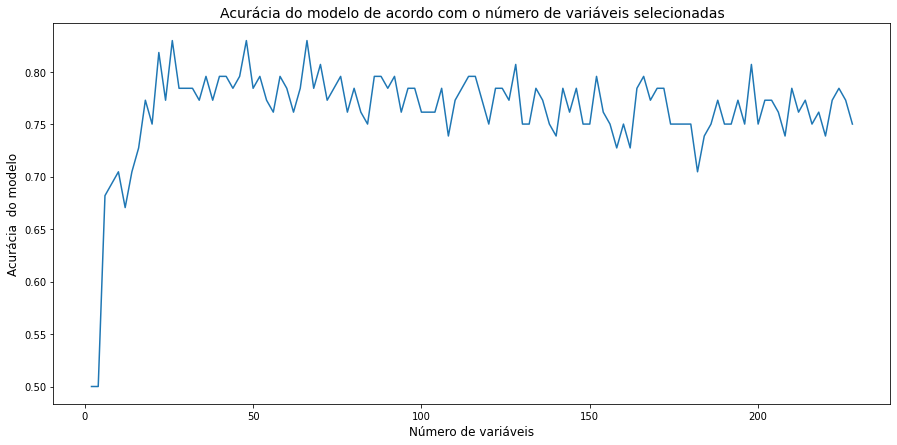

In [ ]:
pd.Series(k_vs_score, index=range(2,230,2)).plot(figsize=(15,7))
plt.title("Acurácia do modelo de acordo com o número de variáveis selecionadas", fontsize=14)
plt.xlabel("Número de variáveis", fontsize=12)
plt.ylabel("Acurácia  do modelo", fontsize=12)
plt.plot()

In [ ]:
# De acordo com o gráfico acima, o melhor desempenho do modelo se dá por volta de 30 variávies
# Selecionando as 30 melhores
selector = SelectKBest(score_func=f_classif, k=30)
selector.fit(X_train, y_train)

SelectKBest(k=30)

In [ ]:
# Vendo o nome das colunas das 30 melhores variáveis
mask = selector.get_support()
X_test.columns[mask]

Index(['AGE_ABOVE65', 'AGE_PERCENTIL', 'CALCIUM_MEDIAN', 'CALCIUM_MEAN',
       'CALCIUM_MIN', 'CALCIUM_MAX', 'GLUCOSE_MEDIAN', 'GLUCOSE_MEAN',
       'GLUCOSE_MIN', 'GLUCOSE_MAX', 'LACTATE_MEDIAN', 'LACTATE_MEAN',
       'LACTATE_MIN', 'LACTATE_MAX', 'PCR_MEDIAN', 'PCR_MEAN', 'PCR_MIN',
       'PCR_MAX', 'SODIUM_MEDIAN', 'SODIUM_MEAN', 'SODIUM_MIN', 'SODIUM_MAX',
       'UREA_MEDIAN', 'UREA_MEAN', 'UREA_MIN', 'UREA_MAX',
       'BLOODPRESSURE_DIASTOLIC_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN',
       'BLOODPRESSURE_DIASTOLIC_MIN', 'BLOODPRESSURE_DIASTOLIC_MAX'],
      dtype='object')

In [ ]:
# Fazendo outro teste, usando apenas o resultado mais alto dos exames dos pacientes

In [ ]:
colunas_gerais = dados_limpos.iloc[:,0:13]

In [ ]:
colunas_icu = dados_limpos.iloc[:,-2:]

In [ ]:
colunas_max = []
for nome_coluna in dados_limpos:
  if "MAX" in nome_coluna:
    colunas_max.append(nome_coluna)

In [ ]:
dados_max = dados_limpos[colunas_max]

In [ ]:
colunas_com_max = ['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER',
       'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN',
       'IMMUNOCOMPROMISED', 'OTHER', 'ALBUMIN_MAX', 'BE_ARTERIAL_MAX', 'BE_VENOUS_MAX', 'BIC_ARTERIAL_MAX',
       'BIC_VENOUS_MAX', 'BILLIRUBIN_MAX', 'BLAST_MAX', 'CALCIUM_MAX',
       'CREATININ_MAX', 'FFA_MAX', 'GGT_MAX', 'GLUCOSE_MAX', 'HEMATOCRITE_MAX',
       'HEMOGLOBIN_MAX', 'INR_MAX', 'LACTATE_MAX', 'LEUKOCYTES_MAX',
       'LINFOCITOS_MAX', 'NEUTROPHILES_MAX', 'P02_ARTERIAL_MAX',
       'P02_VENOUS_MAX', 'PC02_ARTERIAL_MAX', 'PC02_VENOUS_MAX', 'PCR_MAX',
       'PH_ARTERIAL_MAX', 'PH_VENOUS_MAX', 'PLATELETS_MAX', 'POTASSIUM_MAX',
       'SAT02_ARTERIAL_MAX', 'SAT02_VENOUS_MAX', 'SODIUM_MAX', 'TGO_MAX',
       'TGP_MAX', 'TTPA_MAX', 'UREA_MAX', 'DIMER_MAX',
       'BLOODPRESSURE_DIASTOLIC_MAX', 'BLOODPRESSURE_SISTOLIC_MAX',
       'HEART_RATE_MAX', 'RESPIRATORY_RATE_MAX', 'TEMPERATURE_MAX',
       'OXYGEN_SATURATION_MAX', 'WINDOW', 'ICU']

In [ ]:
dados_gerais_max = pd.concat([colunas_gerais, dados_max, colunas_icu],ignore_index=True,axis=1)
dados_gerais_max.columns = colunas_com_max
dados_gerais_max.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MAX,BE_ARTERIAL_MAX,BE_VENOUS_MAX,BIC_ARTERIAL_MAX,BIC_VENOUS_MAX,BILLIRUBIN_MAX,BLAST_MAX,CALCIUM_MAX,CREATININ_MAX,FFA_MAX,GGT_MAX,GLUCOSE_MAX,HEMATOCRITE_MAX,HEMOGLOBIN_MAX,INR_MAX,LACTATE_MAX,LEUKOCYTES_MAX,LINFOCITOS_MAX,NEUTROPHILES_MAX,P02_ARTERIAL_MAX,P02_VENOUS_MAX,PC02_ARTERIAL_MAX,PC02_VENOUS_MAX,PCR_MAX,PH_ARTERIAL_MAX,PH_VENOUS_MAX,PLATELETS_MAX,POTASSIUM_MAX,SAT02_ARTERIAL_MAX,SAT02_VENOUS_MAX,SODIUM_MAX,TGO_MAX,TGP_MAX,TTPA_MAX,UREA_MAX,DIMER_MAX,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.000000,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.77931,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.912243,-0.742004,-0.958528,-0.780261,0.144654,0.158537,-0.959849,1.000000,-0.382773,-0.908714,-0.412965,-0.170732,-0.704142,-0.77931,-0.754601,-0.939887,0.234043,0.363636,-0.399199,-0.703704,0.939394,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.836145,-0.978029,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-0.317073,-0.317073,-0.972789,-1.0,0.326531,-0.968861,-0.194030,-0.316589,-0.891993,-0.203354,-0.219512,-0.959849,-0.828421,-0.729239,-0.836100,-0.784714,-0.170732,-0.633136,-0.77931,-0.779141,-0.503592,0.234043,0.363636,-0.564753,-0.777778,0.939394,0.580247,0.200000,-0.989549,-0.956555,-0.846633,-0.937349,-0.978029,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.935113,-1.0,0.357143,-0.913659,-0.829424,-0.938084,-0.851024,0.358491,0.304878,-0.959849,1.000000,-0.702202,-0.641079,-0.812725,-0.170732,-0.704142,-0.77931,-0.754601,-0.990926,0.234043,0.363636,-0.457944,-0.592593,0.939394,0.345679,0.142857,-0.998507,-0.991235,-0.846633,-0.903614,-1.000000,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,0-2,0
5,25,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.891012,-0.742004,-0.958528,-0.891993,0.291405,0.243902,-0.959849,1.000000,-0.706450,-0.340249,-0.846339,-0.170732,-0.704142,-0.77931,-0.754601,-0.997732,0.234043,0.363636,-0.292390,-0.666667,0.939394,0.345679,0.085714,-0.997947,-0.988948,-0.846633,-0.884337,-1.000000,-0.247863,-0.567568,-0.626866,-0.575758,-0.333333,0.842105,0-2,0


In [ ]:
y = dados_gerais_max['ICU']
x = dados_gerais_max.drop(['ICU', 'WINDOW'], axis=1)
X_train3, X_test3, y_train3, y_test3 = train_test_split(x, y, test_size=0.25, random_state=0)
X_train3.shape, X_test3.shape, y_train3.shape, y_test3.shape 

((264, 55), (88, 55), (264,), (88,))

In [ ]:
from sklearn.metrics import roc_auc_score
k_vs_score = []

for k in range(2,56,2):
  selector = SelectKBest(score_func=f_classif, k=k)

  Xtrain4 = selector.fit_transform(X_train3, y_train3)
  Xtest4 = selector.transform(X_test3)

  mdl = RandomForestClassifier(n_estimators=100, random_state=0)
  mdl.fit(Xtrain4, y_train3)

  p = mdl.predict(Xtest4)

  score = roc_auc_score(y_test, p)
  print("k = {} - ROC_AUC = {}".format(k, score))

  k_vs_score.append(score)

k = 2 - ROC_AUC = 0.6363636363636364
k = 4 - ROC_AUC = 0.6818181818181819
k = 6 - ROC_AUC = 0.7613636363636364
k = 8 - ROC_AUC = 0.784090909090909
k = 10 - ROC_AUC = 0.7840909090909091
k = 12 - ROC_AUC = 0.7500000000000001
k = 14 - ROC_AUC = 0.7499999999999999
k = 16 - ROC_AUC = 0.7840909090909092
k = 18 - ROC_AUC = 0.7727272727272728
k = 20 - ROC_AUC = 0.7613636363636362
k = 22 - ROC_AUC = 0.7500000000000001
k = 24 - ROC_AUC = 0.8068181818181819
k = 26 - ROC_AUC = 0.7954545454545455
k = 28 - ROC_AUC = 0.8068181818181819
k = 30 - ROC_AUC = 0.7613636363636364
k = 32 - ROC_AUC = 0.7954545454545454
k = 34 - ROC_AUC = 0.8068181818181819
k = 36 - ROC_AUC = 0.7727272727272728
k = 38 - ROC_AUC = 0.7840909090909091
k = 40 - ROC_AUC = 0.8068181818181819
k = 42 - ROC_AUC = 0.7840909090909092
k = 44 - ROC_AUC = 0.7727272727272727
k = 46 - ROC_AUC = 0.7727272727272727
k = 48 - ROC_AUC = 0.7954545454545454
k = 50 - ROC_AUC = 0.7613636363636364
k = 52 - ROC_AUC = 0.7727272727272727
k = 54 - ROC_AUC 

In [ ]:
selector1 = SelectKBest(score_func=f_classif, k=28)
selector1.fit(X_train3, y_train3)

SelectKBest(k=28)

In [ ]:
mask1 = selector1.get_support()
X_test3.columns[mask1]

Index(['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER', 'DISEASE GROUPING 2',
       'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'HTN',
       'BE_ARTERIAL_MAX', 'CALCIUM_MAX', 'CREATININ_MAX', 'FFA_MAX',
       'GLUCOSE_MAX', 'HEMATOCRITE_MAX', 'HEMOGLOBIN_MAX', 'INR_MAX',
       'LACTATE_MAX', 'LINFOCITOS_MAX', 'NEUTROPHILES_MAX', 'PC02_VENOUS_MAX',
       'PCR_MAX', 'PH_VENOUS_MAX', 'POTASSIUM_MAX', 'SODIUM_MAX', 'UREA_MAX',
       'BLOODPRESSURE_DIASTOLIC_MAX', 'RESPIRATORY_RATE_MAX',
       'OXYGEN_SATURATION_MAX'],
      dtype='object')

# **Testes**

In [ ]:
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.9

In [ ]:
dados_limpos.insert(4,'DISEASE',0)

In [ ]:
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.0

In [ ]:
def junta_doencas(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    print(rows)

In [ ]:
doencas = dados_limpos.query("DISEASE GROUPING 1==1")['PATIENT_VISIT_IDENTIFIER'].values

SyntaxError: ignored

In [ ]:
import eli5

from eli5.sklearn import PermutationImportance

perm = PermutationImportance(modelo_arvore, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0250 ± 0.0265,PATIENT_VISIT_IDENTIFIER
0.0250 ± 0.0091,BIC_VENOUS_MIN
0.0205 ± 0.0223,TEMPERATURE_MAX
0.0205 ± 0.0170,NEUTROPHILES_MEDIAN
0.0205 ± 0.0223,PH_VENOUS_MIN
0.0182 ± 0.0111,UREA_MIN
0.0182 ± 0.0111,RESPIRATORY_RATE_MIN
0.0159 ± 0.0111,BLOODPRESSURE_DIASTOLIC_DIFF_REL
0.0159 ± 0.0232,BIC_VENOUS_MEDIAN
0.0136 ± 0.0170,BLOODPRESSURE_SISTOLIC_DIFF
